In [109]:
from rdkit.Chem import AllChem as Chem
from rdkit.Chem import MACCSkeys
# import modin.pandas as pd

In [13]:
MACCSkeys.smartsPatts[2]

('[#104]', 0)

In [49]:
maccs = []
for idx, (patt, ni) in MACCSkeys.smartsPatts.items():
    sm = Chem.MolFromSmarts(patt)
    if sm:
        maccs.append(sm)
    else:
        maccs.append(None)

[12:28:32] SMARTS Parse Error: syntax error while parsing: ?
[12:28:32] SMARTS Parse Error: Failed parsing SMARTS '?' for input: '?'
[12:28:32] SMARTS Parse Error: syntax error while parsing: ?
[12:28:32] SMARTS Parse Error: Failed parsing SMARTS '?' for input: '?'
[12:28:32] SMARTS Parse Error: syntax error while parsing: ?
[12:28:32] SMARTS Parse Error: Failed parsing SMARTS '?' for input: '?'


In [42]:
mtor = pd.read_csv("../../data/chembl_mtor_ic50.csv", delimiter=";")
mtor = mtor[["Molecule ChEMBL ID", "Smiles"]]
mtor["mol"] = mtor.apply(lambda row: Chem.MolFromSmiles(row["Smiles"]), axis=1)
mtor["Source"] = "mtor"
mtor.rename({"Molecule ChEMBL ID":"ID"}, axis=1, inplace=True)

drugbank_mols =  Chem.SDMolSupplier('../../data/drugbank.sdf')
drugbank = [mol for mol in drugbank_mols if mol]
pd_drugbank = pd.DataFrame(drugbank, columns=["mol"])
pd_drugbank["Smiles"] = pd_drugbank.apply(lambda row: Chem.MolToSmiles(row["mol"]), axis=1)
pd_drugbank["Source"] = "drugbank"
pd_drugbank["ID"] = pd_drugbank.apply(lambda row: row["mol"].GetProp("DATABASE_ID"), axis=1)

df = pd.concat([mtor, pd_drugbank]).reset_index(drop=True)

[12:24:36] Explicit valence for atom # 7 N, 4, is greater than permitted
[12:24:36] ERROR: Could not sanitize molecule ending on line 20009
[12:24:36] ERROR: Explicit valence for atom # 7 N, 4, is greater than permitted
[12:24:36] Can't kekulize mol.  Unkekulized atoms: 1 2 3 5 6 7 8 9 10
[12:24:36] ERROR: Could not sanitize molecule ending on line 250947
[12:24:36] ERROR: Can't kekulize mol.  Unkekulized atoms: 1 2 3 5 6 7 8 9 10
[12:24:36] Explicit valence for atom # 17 O, 3, is greater than permitted
[12:24:36] ERROR: Could not sanitize molecule ending on line 258130
[12:24:36] ERROR: Explicit valence for atom # 17 O, 3, is greater than permitted
[12:24:36] Can't kekulize mol.  Unkekulized atoms: 57 58 59 60 61 62 63 64 65
[12:24:36] ERROR: Could not sanitize molecule ending on line 261581
[12:24:36] ERROR: Can't kekulize mol.  Unkekulized atoms: 57 58 59 60 61 62 63 64 65
[12:24:36] Explicit valence for atom # 47 Mg, 4, is greater than permitted
[12:24:36] ERROR: Could not sanitize

In [50]:
fp = MACCSkeys.GenMACCSKeys(df["mol"][0])
fp.ToList()
fp.GetOnBits()

In [48]:
df_data = pd.DataFrame(list(
    df.apply(
        lambda row: MACCSkeys.GenMACCSKeys(row["mol"]), axis=1)),
    columns=["MACCS"])
df = df.join(df_data)

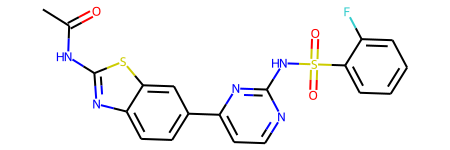

In [60]:
list(df["MACCS"][0].GetOnBits())
df["mol"][0]

In [69]:
maccs_stats_DB = list(
    df[df["Source"] == "drugbank"].apply(
        lambda row: list(row["MACCS"].GetOnBits()), axis=1))
maccs_stats_m = list(
    df[df["Source"] == "mtor"].apply(
        lambda row: list(row["MACCS"].GetOnBits()), axis=1))

In [88]:
maccs_stats_DB_ = {}
maccs_stats_m_ = {}
for mol in maccs_stats_DB:
    for bit in mol:
        if not bit in maccs_stats_DB_:
            maccs_stats_DB_[bit] = 1
        else:    
            maccs_stats_DB_[bit] += 1
        
for mol in maccs_stats_m:
    for bit in mol:
        if not bit in maccs_stats_m_:
            maccs_stats_m_[bit] = 1
        else:
            maccs_stats_m_[bit] += 1

In [93]:
DB_stats = sorted(maccs_stats_DB_.items(), key=lambda x: -x[1])
m_stats = sorted(maccs_stats_m_.items(), key=lambda x: -x[1])

In [98]:
clen_db = len(df[df["Source"] == "drugbank"])
count_db = {k: n/clen_db for k, n in DB_stats}
clen_m = len(df[df["Source"] == "mtor"])
count_m = {k: n/clen_m for k, n in m_stats}

In [105]:
for i in range(167):
    if not i in count_db:
        count_db[i] = 0
    if not i in count_m:
        count_m[i] = 0

In [106]:
dif = {x: count_m[x]-count_db[x] for x in range(167)}

In [122]:
sorted(dif.items(), key=lambda x: x[1])[:10]

[(139, -0.3830701627843551),
 (90, -0.3485238663147203),
 (91, -0.31666727233150493),
 (123, -0.306653430136928),
 (104, -0.2907119645234574),
 (54, -0.28638650813664823),
 (72, -0.2238740965958333),
 (140, -0.22382757052416438),
 (53, -0.19178349574327738),
 (136, -0.1729773272120807)]

In [137]:
mol = Chem.MolFromSmiles("CCCCCC")
fp = (Chem.GetMorganFingerprintAsBitVect(mol, 3, 2048))
list(fp.GetOnBits())

[80, 294, 417, 591, 794, 1057, 1444, 1911]

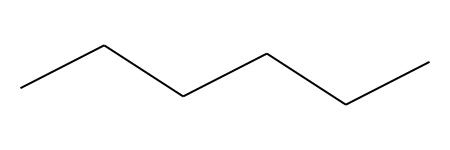

In [138]:
fp2 = Chem.GetMorganFingerprint(mol, 3)
mol

In [139]:
fp2.GetNonzeroElements()

{1173125914: 2,
 1510461303: 2,
 1685248591: 2,
 2245384272: 4,
 2246728737: 2,
 3213857185: 1,
 3542456614: 2,
 3745584548: 2}

In [140]:
bitinfo = {}
fp = Chem.GetMorganFingerprint(mol, 3, bitInfo=bitinfo)
bitinfo

{1173125914: ((1, 1), (4, 1)),
 1510461303: ((2, 1), (3, 1)),
 1685248591: ((1, 2), (4, 2)),
 2245384272: ((1, 0), (2, 0), (3, 0), (4, 0)),
 2246728737: ((0, 0), (5, 0)),
 3213857185: ((2, 3),),
 3542456614: ((0, 1), (5, 1)),
 3745584548: ((2, 2), (3, 2))}

In [199]:
def mol_frags_to_smiles(mol, radius=3):
    bitinfo = {}
    fp = Chem.GetMorganFingerprint(mol, radius=radius, bitInfo=bitinfo)
    smiles = {}
    for k, v in bitinfo.items():
        i = v[0]
        amap = {}
        env = Chem.FindAtomEnvironmentOfRadiusN(mol,i[1],i[0], atomMap=amap)
        if len(env) > 0:
            submol=Chem.PathToSubmol(mol,env)
            smiles[k] = Chem.MolToSmiles(submol)
        else:
            i = next(iter(amap.keys()))
            smiles[k] = mol.GetAtomWithIdx(i).GetSymbol()
        
    return smiles

In [198]:
# molecule, radius, atom
amap = {}
env = Chem.FindAtomEnvironmentOfRadiusN(mol,0,4, atomMap=amap)
submol=Chem.PathToSubmol(mol,env)
Chem.MolToSmiles(submol)
i = next(iter(amap.keys()))
# Chem.MolFromSmiles()


'C'

In [201]:
mol_frags_to_smiles(df["mol"][0])

{150310: 'ccc(cc)-c(c)n',
 43357009: 'cNC(C)=O',
 63829641: 'cnc(nc)NS',
 64070612: 'cc(-c)n',
 98513984: 'ccc',
 186125063: 'SNc1ncccn1',
 288315894: 'cS(N)(=O)=O',
 325679369: 'NS(=O)(=O)c1ccccc1F',
 347464326: 'cnc(nc)NS(=O)(=O)c(c)c',
 367653851: 'Nc1nc2ccccc2s1',
 411967733: 'CC(N)=O',
 601309219: 'cnc(NC(C)=O)sc',
 617331537: 'ccc(nc)-c1cccc(s)c1',
 776134841: 'c-c1ccnc(N)n1',
 814591537: 'ccc1sc(NC)nc1c',
 847961216: 'N',
 864942730: 'O',
 882399112: 'F',
 948573493: 'cnc1ccc(-c)cc1s',
 951226070: 'ccc',
 981811280: 'cS(=O)(=O)Nc(n)n',
 994485099: 'ccc',
 999334238: 'S',
 1012533964: 'cc(c)nc(N)s',
 1023209243: 'ccnc(n)N',
 1100037548: 'cnc',
 1101219341: 'cc1nc(NC(C)=O)sc1c',
 1101907775: 'cnc',
 1103832125: 'c-c(n)ccn',
 1229325558: 'cNS',
 1269851781: 'ccc(sc)c(c)n',
 1510328189: 'C=O',
 1550458325: 'cc(c)-c1ccnc(NS)n1',
 1790668568: 'CNc',
 1791271074: 'csc',
 1857396528: 'cc(c)F',
 1940357627: 'ccc(F)c(c)S',
 2041434490: 'N',
 2149453589: 'ccc(c(c)F)S(N)(=O)=O',
 2228063684